In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Softmax, concatenate, Layer
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
print(tf.__version__)

2.0.0


# Reuters dataset: Model subclassing and custom training loops

#### Start by defining again the layers and model with model subclassing

In [103]:
class my_layer(Layer):

  def __init__(self, units, input_dim):
    super(my_layer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros',
                             trainable=True)
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

class my_dropout(Layer):

  def __init__(self, rate):
    super(my_dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
        return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class my_model(Model):

  def __init__(self, units_1, input_dim_1, units_2, input_dim_2, units_3, input_dim_3):
    super(my_model, self).__init__()
    self.layer_1 = my_layer(units_1, input_dim_1)
    self.dropout_1 = my_dropout(0.5)
    self.layer_2 = my_layer(units_2, input_dim_2)
    self.dropout_2 = my_dropout(0.5)
    self.layer_3 = my_layer(units_3, input_dim_3)
    self.softmax = Softmax()

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = tf.nn.relu(x)
    x = self.dropout_1(x)
    x = self.layer_2(x)
    x = tf.nn.relu(x)
    x = self.dropout_2(x)
    x = self.layer_3(x)
    return self.softmax(x)

model = my_model(64,10000,64,64,46,64)
model(tf.ones((1, 10000)))
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (my_layer)        multiple                  640064    
_________________________________________________________________
my_dropout_2 (my_dropout)    multiple                  0         
_________________________________________________________________
my_layer_4 (my_layer)        multiple                  4160      
_________________________________________________________________
my_dropout_3 (my_dropout)    multiple                  0         
_________________________________________________________________
my_layer_5 (my_layer)        multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

#### Load the reuters dataset and define the class_names 

In [104]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

print("     Label: {}".format(class_names[train_labels[0]]))

     Label: earn


#### Show a text sample from the reuters dataset. Reverse a dictionary to see words instead of integers

In [105]:
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(decoded_newswire)


? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Create a bag of words for each sample

*Define a function that creates a vector of 10000 elements, with each element being the number of times that a word is contained in a text sample*

In [106]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 10000)
x_test  (2246, 10000)


#### Convert the labels to one hot encoder



In [107]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("one_hot_train_labels ", one_hot_train_labels.shape)
print("one_hot_test_labels ", one_hot_test_labels.shape)

one_hot_train_labels  (8982, 46)
one_hot_test_labels  (2246, 46)


#### Define the loss function and optimizer



In [108]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def loss(model, x, y):
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Employ `tf.GradientTape` to compute the gradients for the training loop

In [109]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Set up the training loop

In [110]:
# Reduce the train dataset to haste the training time
x_train_small=x_train[:500,:]
one_hot_train_labels_small=one_hot_train_labels[:500,:]

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

# Measure the training time
start_time = time.time()

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop
  for i in range(len(x_train_small)):
    # Optimize the model
    loss_value, grads = grad(model, x_train_small[np.newaxis,i], one_hot_train_labels_small[np.newaxis,i])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(one_hot_train_labels_small[np.newaxis,i], model(x_train_small[np.newaxis,i]))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.150, Accuracy: 51.200%
Epoch 001: Loss: 1.225, Accuracy: 66.200%
Epoch 002: Loss: 0.726, Accuracy: 81.400%
Epoch 003: Loss: 0.412, Accuracy: 91.000%
Epoch 004: Loss: 0.238, Accuracy: 95.000%
Epoch 005: Loss: 0.131, Accuracy: 96.800%
Epoch 006: Loss: 0.072, Accuracy: 98.600%
Epoch 007: Loss: 0.035, Accuracy: 99.200%
Epoch 008: Loss: 0.020, Accuracy: 99.800%
Epoch 009: Loss: 0.005, Accuracy: 100.000%
Duration :47.523


#### Plot the loss and accuracy evolution throughout the epochs

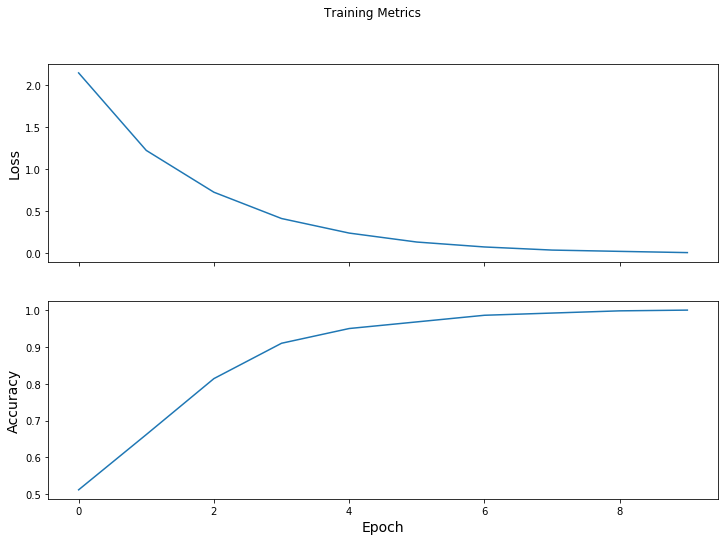

In [111]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Show an example of predicted label

In [112]:
predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


## Additional: tf.function decorator

#### Set up the `@tf.function` before the definition of the grad function

In [113]:
@tf.function
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Run the training loop, paying attention to the decrease in computational time

In [114]:
x_train_small=x_train[:500,:]
one_hot_train_labels_small=one_hot_train_labels[:500,:]


# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

start_time = time.time()

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop - using batches of 32
  for i in range(len(x_train_small)):
    # Optimize the model
    loss_value, grads = grad(model, x_train_small[np.newaxis,i], one_hot_train_labels_small[np.newaxis,i])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(one_hot_train_labels_small[np.newaxis,i], model(x_train_small[np.newaxis,i]))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 0.002, Accuracy: 100.000%
Epoch 001: Loss: 0.001, Accuracy: 100.000%
Epoch 002: Loss: 0.000, Accuracy: 100.000%
Epoch 003: Loss: 0.000, Accuracy: 100.000%
Epoch 004: Loss: 0.000, Accuracy: 100.000%
Epoch 005: Loss: 0.000, Accuracy: 100.000%
Epoch 006: Loss: 0.000, Accuracy: 100.000%
Epoch 007: Loss: 0.000, Accuracy: 100.000%
Epoch 008: Loss: 0.000, Accuracy: 100.000%
Epoch 009: Loss: 0.000, Accuracy: 100.000%
Duration :29.242


#### Print the `tf.autograph.to_code`

*It shows what TF is doing with the grad function, written in Python source code*

In [115]:
print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('grad', 'grad_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as grad_scope:
    with tf.GradientTape() as tape:
      loss_value = ag__.converted_call(loss, grad_scope.callopts, (model, inputs, targets), None, grad_scope)
    do_return = True
    retval_ = grad_scope.mark_return_value((loss_value, ag__.converted_call(tape.gradient, grad_scope.callopts, (loss_value, model.trainable_variables), None, grad_scope)))
  do_return,
  return ag__.retval(retval_)

